En este ipynb vienen los problemas 1, 2, y 3, aunque el problema 3 también se entregó por separado en un archivo .py para poder correrlo.
Los pseudocódigos de RANSAC, Homografía y 8-point algorithm se extrajeron del libro Multiple View Geometry in Computer Vision de Richard Hartley and Andrew Zisserman y se complementó con los códigos vistos en clase.

Using the code for matching feature points that we already saw in class, implement a
\textbf{RANSAC-based homography estimation algorithm}. For that, you are asked:
- to implement a function that estimates a homography from 4 matches;
- to write the RANSAC loop that selects 4 matches randomly, estimates the corresponding
homography and evaluates the consensus its gets from the set of matches;
- to implement the DLT algorithm to re-estimate the homography from all the inlier matches
resulting from the step before.

In [1]:
#strongly inspired by
# https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

import open3d as o3d

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

In [2]:
 
def estimar_homografia(p1, p2):
    A = []
    for i in range(len(p1)):
        x, y = p1[i]
        u, v = p2[i]
        fila1 = [-x, -y, -1, 0, 0, 0, x*u, y*u, u]
        fila2 = [0, 0, 0, -x, -y, -1, x*v, y*v, v]
        A.append(fila1)
        A.append(fila2)
    A = np.array(A)
    
    ATA = A.T@A
    
    eigenvalores, eigenvectores = np.linalg.eig(ATA)
    #tomamos el indice con menor valor
    indice_menor = np.argmin(np.abs(eigenvalores))
    h = eigenvectores[:, indice_menor]
    H = h.reshape(3, 3)
    
    #ahora normalizamos 
    H = H/H[2, 2]  
    
    return H    

In [3]:
#ahora vamos a programar el algoritmos de ransac
def ransac(puntos1, puntos2, num_iter, tolerancia):
    
    T = len(puntos1) + 1 #esto nos desactiva el if del paso iii) de manera definitiva (podemos cambairlo después)
    mejor_H = None
    mejor_conjunto_inliers = []
    for i in range(num_iter): #(este es el paso iv))
        # i) randomly select a sample of 4 data points from S and
        #instantiate the model from this subset
        indices = random.sample(range(len(puntos1)), 4)
        sample1 = puntos1[indices]
        sample2 = puntos2[indices]
    
        #calcular la homografía
        H = estimar_homografia(sample1, sample2)
    
        #ii) determine the set of data points S_i which are within a distance threshold t of the model.
        #the set S_i is the consensus set of the sample and defines the inliers of S.
        
        inliers = []
        for j in range(len(puntos1)):
            #aquí los hacemos homogeneos
            punto1_h = np.array([puntos1[j][0], puntos1[j][1], 1])
            #le aplicamos la homografía a cada punto
            punto_estimado = H @ punto1_h
            punto_estimado = punto_estimado/punto_estimado[2]
            #compararemos con el punto real
            distancia = np.linalg.norm(punto_estimado[:2] - puntos2[j])
            if distancia < tolerancia:
                inliers.append(j)
                
        #iii) If the size of S_i is greater than T (tolerancia), re-estiimate the model ussing all the points in S_i and terminate
        inliers = np.array(inliers)
        numero_inliers = len(inliers)
        
        if numero_inliers > T:
            #volvemos a calcular la homografía y terminamos
            H_final = estimar_homografia(puntos1[inliers], puntos2[inliers])
            return H_final, inliers
        
        #iv is the size of S_i is less than T, select a new subtset and repeat above (esto fue el for de todo el codigo)
        #v) After N trials the largest consensus set S_i is selected and he model is re-estimated using all the
        #points in the subset S_i.
        if numero_inliers > len(mejor_conjunto_inliers):
            #mejor_H = H
            mejor_conjunto_inliers = inliers
    if len(mejor_conjunto_inliers) == 0:
        return None, []
            
    H_final = estimar_homografia(puntos1[mejor_conjunto_inliers], puntos2[mejor_conjunto_inliers])
    return H_final, mejor_conjunto_inliers
        
        
        
    
        
    

    


In [5]:
def registerImage_modificada(im1, im2):
    
    #convertimos imágenes a escala de grises
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    #detect ORB features and compute descriptors
    orb =cv2.ORB_create(MAX_FEATURES) #create an ORB object
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None) #detect keypoints and compute descriptors
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    
    #match features
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))
    
    #sort matches by score
    matches.sort(key=lambda x: x.distance, reverse = False)
    
    #remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    print("Good matches found: {}".format(numGoodMatches))
    
    #draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    
    plt.imshow(imMatches)
    plt.axis('off')
    plt.show()
    
    #extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
        
    #ahora tomaremos un sample de 4 puntos para cada set de puntos
    #tolerancia  =  4
    h, inliners = ransac(points1, points2, num_iter=1000, tolerancia =  5)
    h = np.array(h, dtype=np.float32)
    #use homography
    height, width, channels = im2.shape
    if h is None or h.shape != (3, 3):
        raise ValueError("La matriz de homografía no es válida")

    h = np.array(h, dtype=np.float32)

    
    return cv2.warpPerspective(im1, h, (width, height)), h
    

In [6]:
#read reference image
refFilename = "im1.jpeg"
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

#read image to be aligned
imFilename = "im3.jpeg"
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

imReg, h = registerImage_modificada(im, imReference)

#write aligned image to disk
plt.imshow(imReg)
plt.axis('off')
print("esta imagen es plot")
plt.show()
#print estimated homography
print("Estimated homography : \n", h)

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


# Problem 2
Use again the same code for matching feature points commented above, implement a \textbf{RANSAC-based 8-point fundamental matrix estimation algorithm}. For that, you are asked:
- to implement a function that estimates a fundamental matrix from 8 matches;
- to write the RANSAC loop that selects 8 matches randomly, estimates the corresponding
fundamental matrix and evaluates the consensus its gets from the set of matches;
- to implement the DLT algorithm to re-estimate the fundamental matrix from all the inlier
matches resulting from the step before.


In [8]:
MAX_FEATURES= 500
GOOD_MATCH_PERCENT = 0.15
# Two images from a stereo pair
img1 = cv2.imread('im1.jpeg',0) #0 means grayscale
img2 = cv2.imread('im3.jpeg',0)

In [9]:
#Detect ORB features and compute descriptors
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

#match features and get the list of matches
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = list(matcher.match(descriptors1, descriptors2, None))
#print(type(matches))


#sort matches by score
matches.sort(key=lambda x: x.distance, reverse = False)

#remove not so good matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]
print("Good matches found: {}".format(numGoodMatches))

Good matches found: 0


In [10]:
#Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

In [11]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1- image on which we draw the epilines for the points in img2
    lines- corresponding epilines '''
    r, c = img1.shape
    nimg1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    nimg2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        #random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        cv2.line(nimg1, (x0, y0), (x1, y1), color, 2)
        cv2.circle(nimg1, tuple(pt1), 5, color, -1)
        cv2.circle(nimg2, tuple(pt2), 5, color, -1)
    return nimg1, nimg2

In [12]:
def eight_point_algorithm(puntos1, puntos2):
    #i) normalization:
    #primero vamos a normalizar nuestros puntos
    centroide_x_pts1 = np.mean(puntos1[:, 0])
    centroide_y_pts1 = np.mean(puntos1[:, 1])
    centroide_x_pts2 = np.mean(puntos2[:, 0])
    centroide_y_pts2 = np.mean(puntos2[:, 1])
    
    #así
    centroide_pts1 = np.array([centroide_x_pts1, centroide_y_pts1])
    centroide_pts2 = np.array([centroide_x_pts2, centroide_y_pts2])
    #ahora vamos a restarle el centroide a cada punto
    puntos1_mod = puntos1 - centroide_pts1
    puntos2_mod = puntos2 - centroide_pts2
    #luego la distancia media al origen
    distancia_media_pts1 = np.mean(np.linalg.norm(puntos1_mod, axis=1))
    distancia_media_pts2 = np.mean(np.linalg.norm(puntos2_mod, axis=1))
    
    #ahora escaramos para que la distancia media sea raiz de 2
    escala_pts1 = np.sqrt(2) / distancia_media_pts1
    escala_pts2 = np.sqrt(2) / distancia_media_pts2
    
    #y multiplicamos por cada punto
    puntos1_mod = puntos1_mod * escala_pts1
    puntos2_mod = puntos2_mod * escala_pts2
    
    #ahora vamos a contruir la matriz de transformación T
    T1 = np.array([[escala_pts1, 0, -escala_pts1*centroide_x_pts1],
                  [0, escala_pts1, -escala_pts1*centroide_y_pts1],
                  [0, 0, 1]])
    
    T2 = np.array([[escala_pts2, 0, -escala_pts2*centroide_x_pts2],
                  [0, escala_pts2, -escala_pts2*centroide_y_pts2],
                  [0, 0, 1]])
    
    #ii) find the fundamental matrix F' corresponding to the matches x_i_gorro <-> x_i_gorro' by
    #a) linear solution (Determine F from the singular vector corresponding 
    # to the smalles singular value of A, A from matches x_i_gorro <-> x_i_gorro')
    #primero construimos la matriz A
    A = []
    for i in range(len(puntos1_mod)):
        x, y = puntos1_mod[i]
        u, v = puntos2_mod[i]
        fila = [x*u, x*v, x, y*u, y*v, y, u, v, 1]
        A.append(fila)
    A = np.array(A)
    #luego le aplicamos SVD
    U, S, Vt = np.linalg.svd(A)
    #y tomamos la última columna 
    F_gorro = Vt[-1].reshape(3, 3)
    
    #b) constrain enforcement: Replace F by F' such that det(F') = 0 using SVD
    #vamos a aplicar SVD a la F_norm
    U_f_gorro, S_f_gorro, Vt_f_gorro= np.linalg.svd(F_gorro)
    S_f_gorro[-1] = 0 #sustituimos el último valor singular por cero
    #y procedemos a hacer la reconstrucción de F
    F_gorro_prima = U_f_gorro @ np.diag(S_f_gorro) @ Vt_f_gorro
    
    # iii) Denormalization: Set F = T2 F T1. Matrix F is the fundamental Matrix corresponding to the original data x_i <-> x_i'
    F = T2.T @ F_gorro_prima @ T1 
    return F
    
    
    
    
    

In [13]:
#modificamos el ransac que ya teníamos para que función con 8point algorithm
def ransac_prob2(puntos1, puntos2, num_iter, tolerancia):
    #vamos a homogeneizar los puntos por fuera
    #puntos1 = np.hstack((puntos1, np.ones((len(puntos1), 1))))
    #puntos2 = np.hstack((puntos2, np.ones((len(puntos2), 1))))
    T = len(puntos1) + 1 #esto nos desactiva el if del paso iii) de manera definitiva (podemos cambairlo después)
    mejor_H = None
    mejor_conjunto_inliers = []
    
    for i in range(num_iter): #(este es el paso iv))
        # i) randomly select a sample of 8 data points from S and
        #instantiate the model from this subset
        indices = random.sample(range(len(puntos1)), 8)
        sample1 = puntos1[indices]
        sample2 = puntos2[indices]
    
        #calculamos los coeficien
        F = eight_point_algorithm(sample1, sample2)
        
    
        #ii) determine the set of data points S_i which are within a distance threshold t of the model.
        #the set S_i is the consensus set of the sample and defines the inliers of S.
        
        inliers = []
        for j in range(len(puntos1)):
            #aquí los hacemos homogeneos
            punto1_h = np.array([puntos1[j][0], puntos1[j][1], 1])
            punto2_h = np.array([puntos2[j][0], puntos2[j][1], 1])
            #linea epipolar
            l2 = F @ punto1_h
            l1 = F.T @ punto2_h
            #distancia epipolar (punto2_h @ F @ punto1_h)/np.linalg.norm(F @ punto1_h[:2])
            numerador = np.abs(punto2_h.T @ F @ punto1_h)
            denominador = np.linalg.norm(F @ punto1_h)
            distancia_epipolar = numerador/denominador
            
            if distancia_epipolar < tolerancia:
                inliers.append(j)
            
        #iii) If the size of S_i is greater than T (tolerancia), re-estiimate the model ussing all the points in S_i and terminate
        inliers = np.array(inliers)
        numero_inliers = len(inliers)
        
        if numero_inliers > T:
            #volvemos a calcular la homografía y terminamos
            F_final = eight_point_algorithm(puntos1[inliers], puntos2[inliers])
            return F_final, inliers
        
        #iv is the size of S_i is less than T, select a new subtset and repeat above (esto fue el for de todo el codigo)
        #v) After N trials the largest consensus set S_i is selected and he model is re-estimated using all the
        #points in the subset S_i.
        if numero_inliers > len(mejor_conjunto_inliers):
            
            mejor_conjunto_inliers = inliers
    if len(mejor_conjunto_inliers) == 0:
        return None, []
            
    F_final = eight_point_algorithm(puntos1[mejor_conjunto_inliers], puntos2[mejor_conjunto_inliers])

    return F_final, mejor_conjunto_inliers
        
        
        

In [19]:
#vamos a probar la matriz F
F, inliers = ransac_prob2(points1, points2, num_iter=1000, tolerancia =  0.1)
print(F)

#solo seleccionamos los puntos de los inliers
points1_inliers = points1[inliers]
points2_inliers = points2[inliers]
puntos1_h = np.hstack((points1_inliers, np.ones((len(points1_inliers), 1))))
puntos2_h = np.hstack((points2_inliers, np.ones((len(points2_inliers), 1))))

errores = []
for i in range(len(points1_inliers)):
    error = puntos2_h[i] @ F @ puntos1_h[i]
    errores.append(error)

error_medio = np.mean(errores)
if error_medio < 0.1:
    print("La matriz F es correcta")
else:
    print("La matriz F no es correcta")
    
    

[[-2.04578648e-06 -6.85873321e-06  8.06506736e-03]
 [ 8.53466571e-06 -2.13211673e-06 -1.07763957e-02]
 [-5.22838547e-03  8.82899070e-03  1.00591790e+00]]
La matriz F es correcta


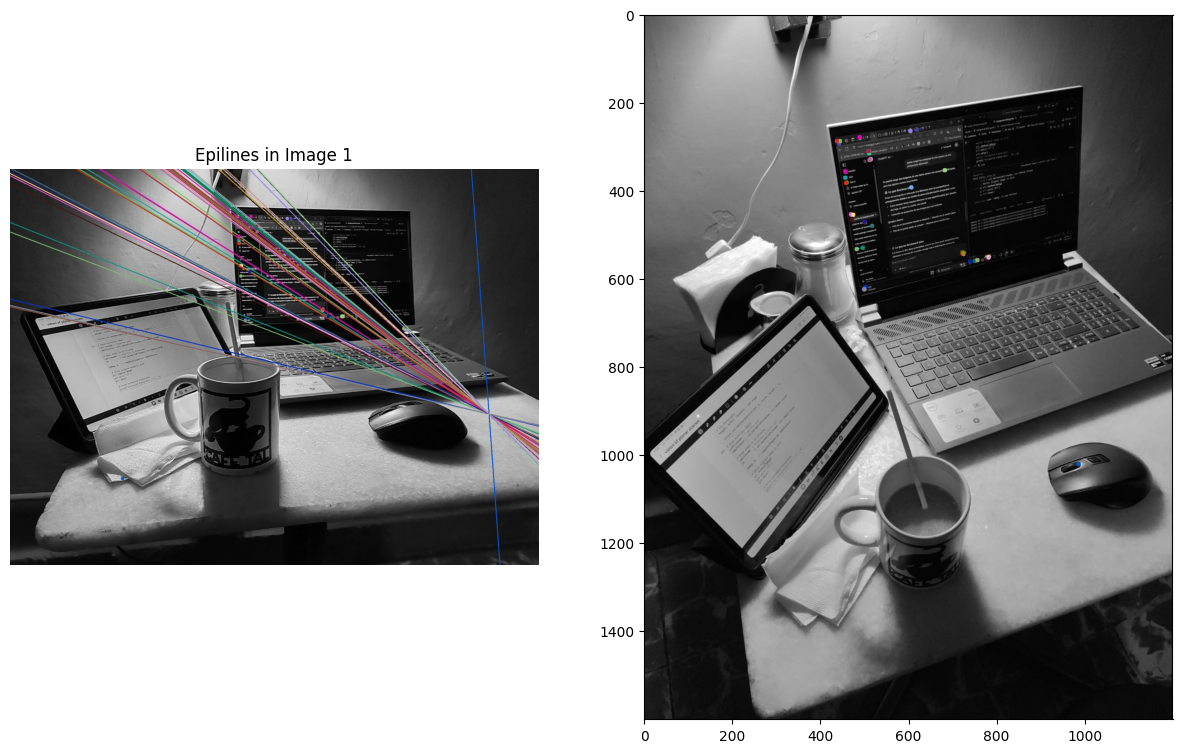

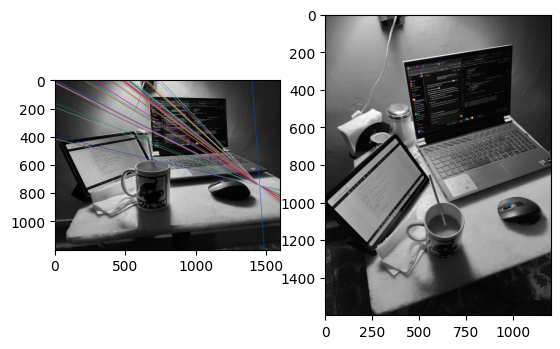

In [20]:
#Find epilines corresponding to points in right image (second image) and 
#drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(points2_inliers.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, points1_inliers.astype(int), points2_inliers.astype(int))

#find epilines corresponding to points in left image (first image) and
#drawing its lines on right imag
lines2 = cv2.computeCorrespondEpilines(points1_inliers.reshape(-1, 1, 2), 2, F)
lines2 = lines2.reshape(-1, 3)
img7, img8 = drawlines(img2, img1, lines2, points2_inliers.astype(int), points1_inliers.astype(int))

fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(img5, cmap='gray')
ax[0].set_title('Epilines in Image 1')
ax[0].axis('off')
ax[1].imshow(img6, cmap='gray')



plt.show()

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img6)
plt.show()

# Problem 3
 Suppose you are working in a company developping autonomous cars and that your are
 assigned the task of detecting the road from a cloud a 3D points generated by a Lidar
 sensor:
 {x_i, y_i, z_i}_i=1, ..., N

  Since these points may be on the road or on other structures (sidewalks, houses, cars...), propose
 and implement a RANSAC algorithm to estimate the road plane (supposing it is a plane! and that
 most of the cloud points come from it).

 You will be given a .ply file corresponding to the Toronto dataset (this is a street in Toronto). To
 read the file and get the 3d point cloud as a numpy array, you can use the open3d library, as shown
 in the following code (which should not run as a notebook, but as a python script).

In [21]:



    
#modificamos el ransac que ya teníamos para que función con 3 puntos, para crear un plano en puntos 3D
def ransac_prob3(puntos1, num_iter, tolerancia):
    
    T = len(puntos1) + 1 #esto nos desactiva el if del paso iii) de manera definitiva (podemos cambairlo después)
    
    mejor_plano = None #aquí va el array con los coeficientes del mejor plano, lo inicializamos en None
    mejor_conjunto_inliers = [] #para guardar el mejor conjunto de inliers
    
    for i in range(num_iter): #(este es el paso iv))
        # i) randomly select a sample of 3 data points from S and
        #vamos a ordenar el conjunto de puntos de menor a mayor en z, para poder tomar un subconjunto de ese conjuto
        #y así evitar que los puntos estén muy separados, eligiendo una muestra dentro del subconjunto
        
        puntos_ordenados = puntos1[puntos1[:, 2].argsort()]
        num_puntos = len(puntos_ordenados)
        subconjunto = puntos_ordenados[: int(num_puntos * 0.1)]
        indices = np.random.choice(len(subconjunto), 3, replace=False)

        sample1 = subconjunto[indices]
        print("Los puntos seleccionados son:", sample1)
        
    
        #ahora vamos a calcular los coeficientes de la ecuación del plano ax+by+cz+d = 0
        
        #para esto vamos a calcular los vectores normales
        v1 = sample1[1] - sample1[0]
        v2 = sample1[2] - sample1[0]
        
        #ahora calculamos el vector normal
        normal = np.cross(v1, v2)
        
        #ahora calculamos el d
        d = -normal @ sample1[0]
        
        #ahora vamos a normalizar el vector normal
        normal = normal/np.linalg.norm(normal)
        a, b, c = normal
        
        
    
        #ii) determine the set of data points S_i which are within a distance threshold t of the model.
        #the set S_i is the consensus set of the sample and defines the inliers of S.
        
        inliers = []
        for j in range(len(puntos1)):
            #vamos a calcular la distancia de un punto a al plano encntrado
            #print("Estamos en la iteracion", i, "y en el punto", j, "con numero de inliers", len(inliers))
            punto = puntos1[j]
            distancia = np.abs(a*punto[0] + b*punto[1] + c*punto[2] + d)/np.sqrt(a**2 + b**2 + c**2)
            if distancia < tolerancia:
                inliers.append(j)
                
        #iii) If the size of S_i is greater than T (tolerancia), re-estiimate the model ussing all the points in S_i and terminate
        inliers = np.array(inliers)
        numero_inliers = len(inliers)
        print("El numero de inliers es:", numero_inliers)
        
        if numero_inliers > T:
            #volvemos a calcular la homografía y terminamos
            puntos_inliers = puntos1[inliers]
            centroide = np.mean(puntos_inliers, axis=0)
            #utilizaremos la matriz de convarianza para ver la dsitribución de los datos
            cov = np.cov(puntos_inliers.T)
            S_cov, V_cov, D_cov = np.linalg.svd(cov)
            nueva_normal = D_cov[-1]
            nueva_d = -nueva_normal @ centroide
            nuevo_a, nuevo_b, nuevo_c = nueva_normal
            mejor_plano = np.array([nuevo_a, nuevo_b, nuevo_c, nueva_d])
            return mejor_plano, inliers
        
        #iv is the size of S_i is less than T, select a new subtset and repeat above (esto fue el for de todo el codigo)
        #v) After N trials the largest consensus set S_i is selected and he model is re-estimated using all the
        #points in the subset S_i.
        if numero_inliers > len(mejor_conjunto_inliers):
            
            mejor_conjunto_inliers = inliers
            mejor_plano = np.array([a, b, c, d])
            #print(f"Normal del plano: {mejor_plano[:3]}")
            
    if len(mejor_conjunto_inliers) == 0:
        return None, []
            
    #recalculamos el mejor plano usando los puntos en el conjunto de inliers
    puntos_inliers = puntos1[mejor_conjunto_inliers]
    centroide = np.mean(puntos_inliers, axis=0)
    
    cov = np.cov(puntos_inliers.T)
    #print("covarianza calculada con puntos_inliers", cov)
    S_cov, V_cov, D_cov = np.linalg.svd(cov)
    nueva_normal = D_cov[2]
    #print("Vectores propios de la matriz de covarianza", D_cov)
    #print("nueva normal", nueva_normal)
    
    nueva_d = -nueva_normal @ centroide
    nuevo_a, nuevo_b, nuevo_c = nueva_normal
    
    

    mejor_plano = np.array([nuevo_a, nuevo_b, nuevo_c, nueva_d])
    
    #print(f"Normal del plano: {mejor_plano[:3]}")
    #print("centroide", centroide)
    #print("varianza de inliers en x", np.var(puntos_inliers[:, 0]))
    

    return mejor_plano, mejor_conjunto_inliers

##dibujar plano

def dibujar_plano(mejor_plano, punto_central, tamano=50.0, color=[0, 1, 0]):
    a, b, c, d = mejor_plano

    # Generamos dos vectores ortogonales al normal para elegir uno de referencia
    normal = np.array([a, b, c])
    if abs(a) > abs(c):  
        v1 = np.array([-b, a, 0])
    else:
        v1 = np.array([0, -c, b])

    v1 = v1 / np.linalg.norm(v1) * tamano
    v2 = np.cross(normal, v1)
    v2 = v2 / np.linalg.norm(v2) * tamano

    # vertices de plano
    puntos_plano = np.array([
        punto_central + v1 + v2,
        punto_central + v1 - v2,
        punto_central - v1 - v2,
        punto_central - v1 + v2
    ])

    # triangulos dela malla
    caras = np.array([
        [0, 1, 2],
        [2, 3, 0]
    ])

    # Crear la malla
    plano_mesh = o3d.geometry.TriangleMesh()
    plano_mesh.vertices = o3d.utility.Vector3dVector(puntos_plano)
    plano_mesh.triangles = o3d.utility.Vector3iVector(caras)
    plano_mesh.paint_uniform_color(color)  # Color verde por defecto

    return plano_mesh


#vamos a correr todo
# leemos 
pcd = o3d.io.read_point_cloud("toronto.ply")

# convertir a numpy array
point_cloud = np.asarray(pcd.points)
print("el numero de puntos es:", len(point_cloud))  # Número de puntos (N)

#vamos a calcular el centroide de la nube
centroide = np.mean(point_cloud, axis=0)
print("El centroide de la nube es:", centroide)
point_cloud_centrada = point_cloud - centroide
# y rescalamos 
escala = np.max(np.abs(point_cloud_centrada), axis=0)
point_cloud_centrada = point_cloud_centrada/escala

# Parámetros
num_iter = 10  # Iteraciones
tolerancia = 0.01   # Tolerancia

# mandamos a llamar nuestra función ransac
mejor_plano, inliers = ransac_prob3(point_cloud_centrada, num_iter, tolerancia)
#y sacamos el plano 
plano_mesh = dibujar_plano(mejor_plano, centroide, tamano=300.0, color=[0, 1, 0])
if mejor_plano is None:
    print("No se encontró un plano en la nube de puntos.")
else:
    print(f"Plano detectado: {mejor_plano}")

    # nube de inliers
    inlier_cloud = point_cloud[inliers]
    
    # visualización de los inliers
    inlier_pcd = o3d.geometry.PointCloud()
    inlier_pcd.points = o3d.utility.Vector3dVector(inlier_cloud)
    
    # marcaremos los inliners en el dibujo
    inlier_pcd.paint_uniform_color([1.0, 0.0, 0.0])  # Rojo
    
    # visualización
    o3d.visualization.draw_geometries([pcd, inlier_pcd, plano_mesh])


el numero de puntos es: 6747648
El centroide de la nube es: [6.27643802e+05 4.84213394e+06 1.37090102e+02]
Los puntos seleccionados son: [[-0.16810564  0.60470999 -0.08329606]
 [-0.17645359  0.42080578 -0.08533015]
 [-0.27614132  0.65219846 -0.08705733]]
El numero de inliers es: 155338
Los puntos seleccionados son: [[-0.28962191  0.66308686 -0.09081919]
 [-0.18081485  0.46995401 -0.08337279]
 [-0.18152506  0.60478027 -0.08298917]]
El numero de inliers es: 156523
Los puntos seleccionados son: [[-0.17153491  0.43943563 -0.08414062]
 [-0.27678288  0.62569187 -0.08556091]
 [-0.13963977  0.30471727 -0.08571436]]
El numero de inliers es: 154523
Los puntos seleccionados son: [[-0.14286287  0.31250229 -0.08594453]
 [-0.23442397  0.46688858 -0.08736482]
 [-0.1518983   0.60913787 -0.08387179]]
El numero de inliers es: 156707
Los puntos seleccionados son: [[-0.31240529  0.65536124 -0.09078053]
 [-0.20300246  0.62846495 -0.08375641]
 [-0.20058117  0.51840468 -0.08402524]]
El numero de inliers es: 

: 